# Импорты

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy

import cvxpy 
import array_to_latex as a2l

In [24]:
sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I

In [25]:
def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

# Задание 1

# Шаг 1

In [26]:
task1_A = np.array([
    [-4, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 5],
    [0, 0, -5, 1]
])

task1_B = np.array(
    [[0], 
    [2], 
    [0], 
    [9]]
)

task1_eigvals = np.array([
    [-4, -4, -4, -4],
    [-4, -40, -400, -400],
    [-4, -8, 5j, -5j],
    [-4, -8, -1 + 5j, -1 - 5j],
])

task1_x0 = np.array([1, 1, 1, 1])

In [27]:
eig_vals = np.linalg.eigvals(task1_A)
eig_vals

array([ 1.+5.j,  1.-5.j, -4.+0.j,  1.+0.j])

In [28]:
for val in eig_vals:
    print(f"   {val}: {'controllable' if np.linalg.matrix_rank(np.hstack(((task1_A - val * np.eye(task1_A.shape[0])), task1_B))) == task1_A.shape[0] else 'not controllable'}")

   (1+5.000000000000001j): controllable
   (1-5.000000000000001j): controllable
   (-4+0j): not controllable
   (1+0j): controllable


## Шаг 3

In [29]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_matrix(A, C):
    obsv_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    assert np.allclose(control.obsv(A, C), obsv_m), 'Smth wrong'
    return obsv_m

def check_controllability(A, B):
    U = get_controllability_matrix(A, B)
    print(f'RankU = {np.linalg.matrix_rank(U)}')
    return np.linalg.matrix_rank(U) == A.shape[0]
        
def check_controllability_eigens(A, B):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")

def check_observability(C, A):
    V = get_observability_matrix(A, C)
    print(f'RankV = {np.linalg.matrix_rank(V)}')
    return np.linalg.matrix_rank(V) == A.shape[0]

def check_observability_eigens(C, A):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")


def task1_get_K(A, B, G, Y):
    P= cvxpy.Variable(A.shape)
    objective = cvxpy.Minimize(cvxpy.sum_squares(A @ P - P @ G - B @ Y))
    prob = cvxpy.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(P.value)}')
    return - Y @ np.linalg.pinv(P.value)

def task1_get_G(specs):
    new_g = np.diag(specs)
    for i in range(1, new_g.shape[0]):
        if new_g[i, i] == new_g[i-1, i-1]:
            new_g[i-1, i] = 1
    if specs[2].imag != 0:
        new_g[2, 2] = specs[2].real
        new_g[3, 3] = specs[2].real
        new_g[2, 3] = specs[2].imag
        new_g[3, 2] = -specs[2].imag
    print(f"Gamma: \n{new_g}")
    return new_g

def task1_get_G_bad(specs):
    base = []
    for i in range(len(specs)):
        rolled = np.array(np.roll([i + 1 for i in range(len(specs))], i))
        base.append(rolled)
    base = np.array(base)
    new_g = np.diag(specs)
    for i in range(1, new_g.shape[0]):
            if new_g[i, i] == new_g[i-1, i-1]:
                new_g[i-1, i] = 1
    if specs[2].imag != 0:
            new_g[2, 2] = specs[2].real
            new_g[3, 3] = specs[2].real
            new_g[2, 3] = specs[2].imag
            new_g[3, 2] = -specs[2].imag
        
    new_g = base @ new_g @ np.linalg.inv(base)
    return new_g
    
    
def task1_simulate(A, B, K, x0, ts):
    print(f'spec(A + B@K): {np.linalg.eigvals(A + B@K)}')
    ss = control.ss(A + B@K, A*0, A*0, A*0)
    return control.forced_response(ss, X0=x0, T=ts)

In [30]:
check_controllability_eigens(task1_A, task1_B)

Eigen values of A:
   [1.+5.j]: controllable
   [1.-5.j]: controllable
   [-4.+0.j]: not controllable
   [1.+0.j]: controllable



======== [-4.+0.j -4.+0.j -4.+0.j -4.+0.j] ========
Gamma: 
[[-4.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -4.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -4.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -4.+0.j]]
Y: 
[[1. 1. 1. 1.]]
Optimization error: 4.2401273655629385e-30, rankP = 3
new_spec: 
[-4.00006805+0.00011788j -4.00006805-0.00011788j -3.99986389+0.j
 -4.        +0.j        ]
RankV = 3
Eigen values of A:
   [-4.+0.j]: not observable
   [-4.+0.j]: not observable
   [-4.+0.j]: not observable
   [-4.+0.j]: not observable
K = [[-8.08216314e-15 -2.50000000e+00 -1.11111111e+00 -1.11111111e+00]]
\begin{bmatrix}
 -0.00 & -2.50 & -1.11 & -1.11
\end{bmatrix}
spec(A + B@K): [-4.00006805+0.00011788j -4.00006805-0.00011788j -3.99986389+0.j
 -4.        +0.j        ]

======== [  -4.+0.j  -40.+0.j -400.+0.j -400.+0.j] ========
Gamma: 
[[  -4.+0.j    0.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j  -40.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j    0.+0.j -400.+0.j    1.+0.j]
 [   0.+0.j    0.+0.j    0.+0.j -400.+0.

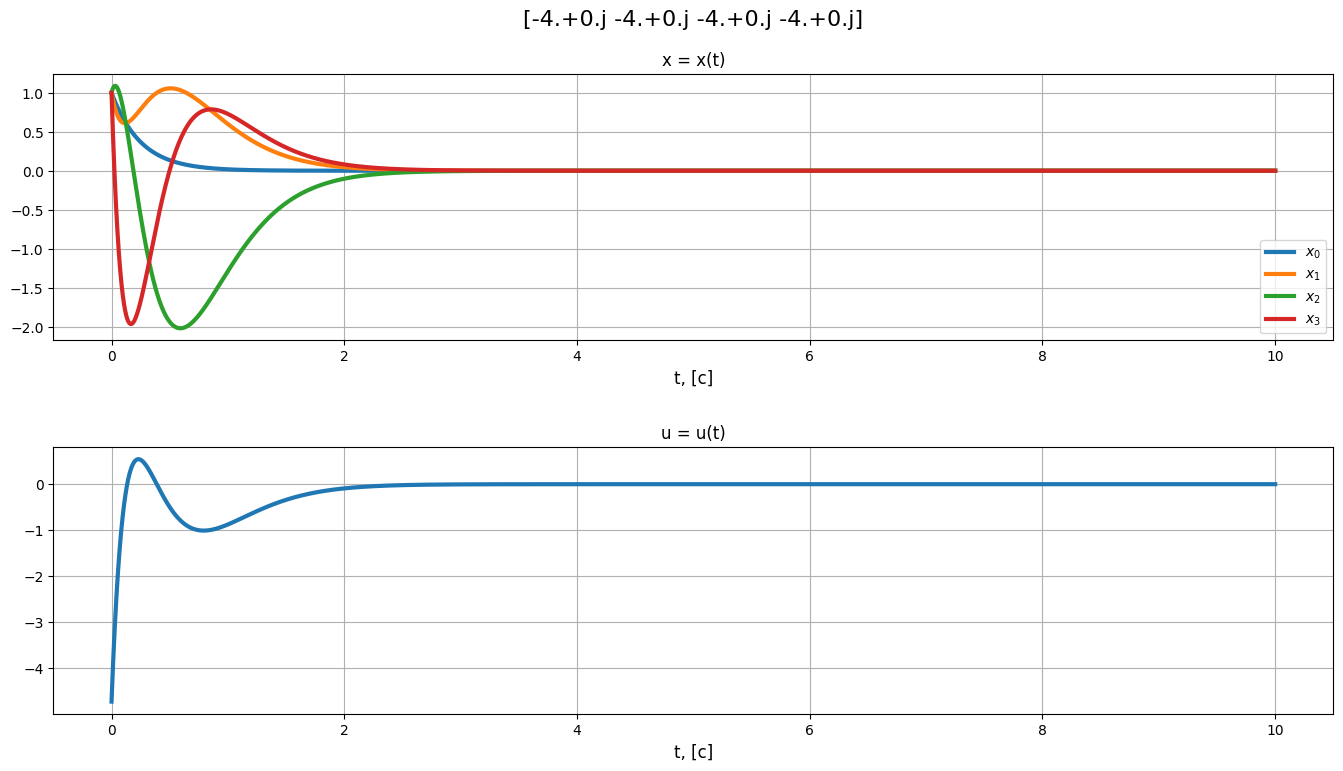

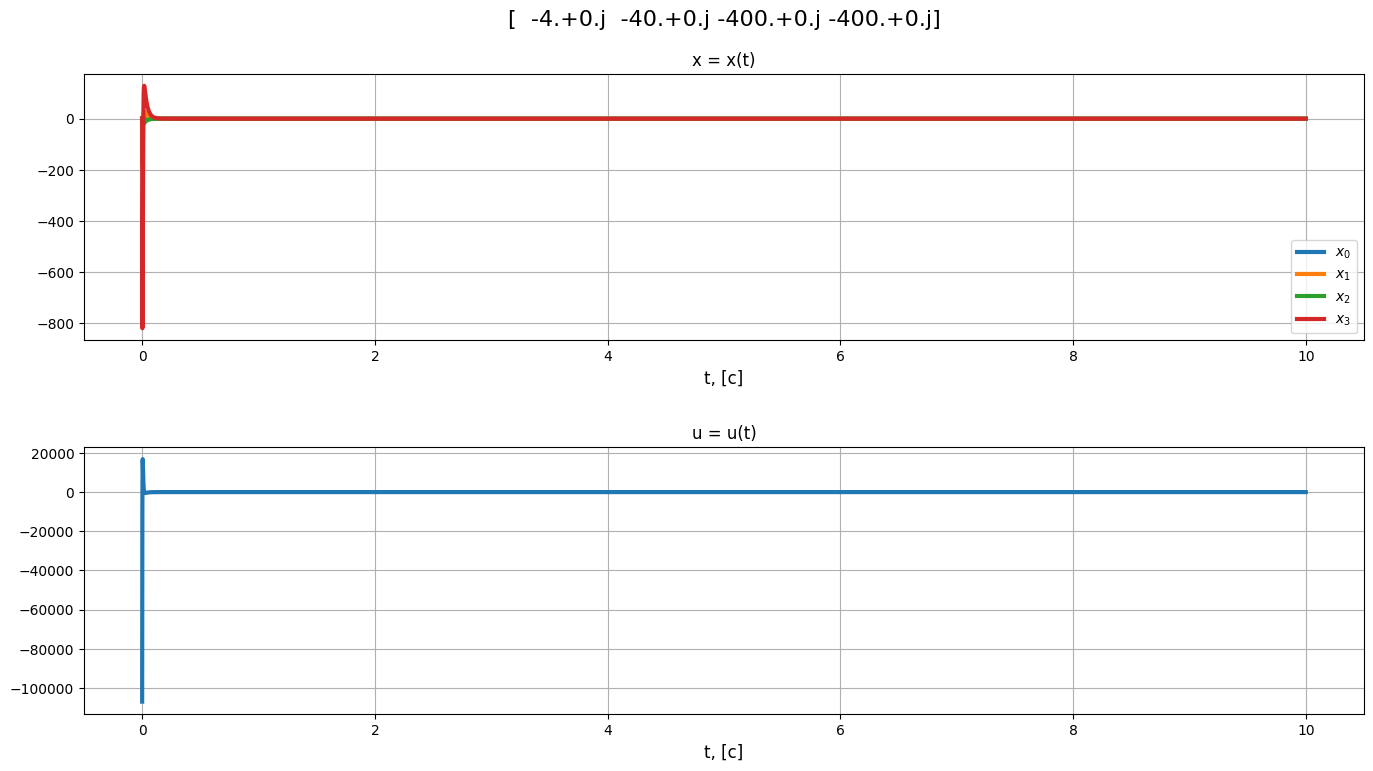

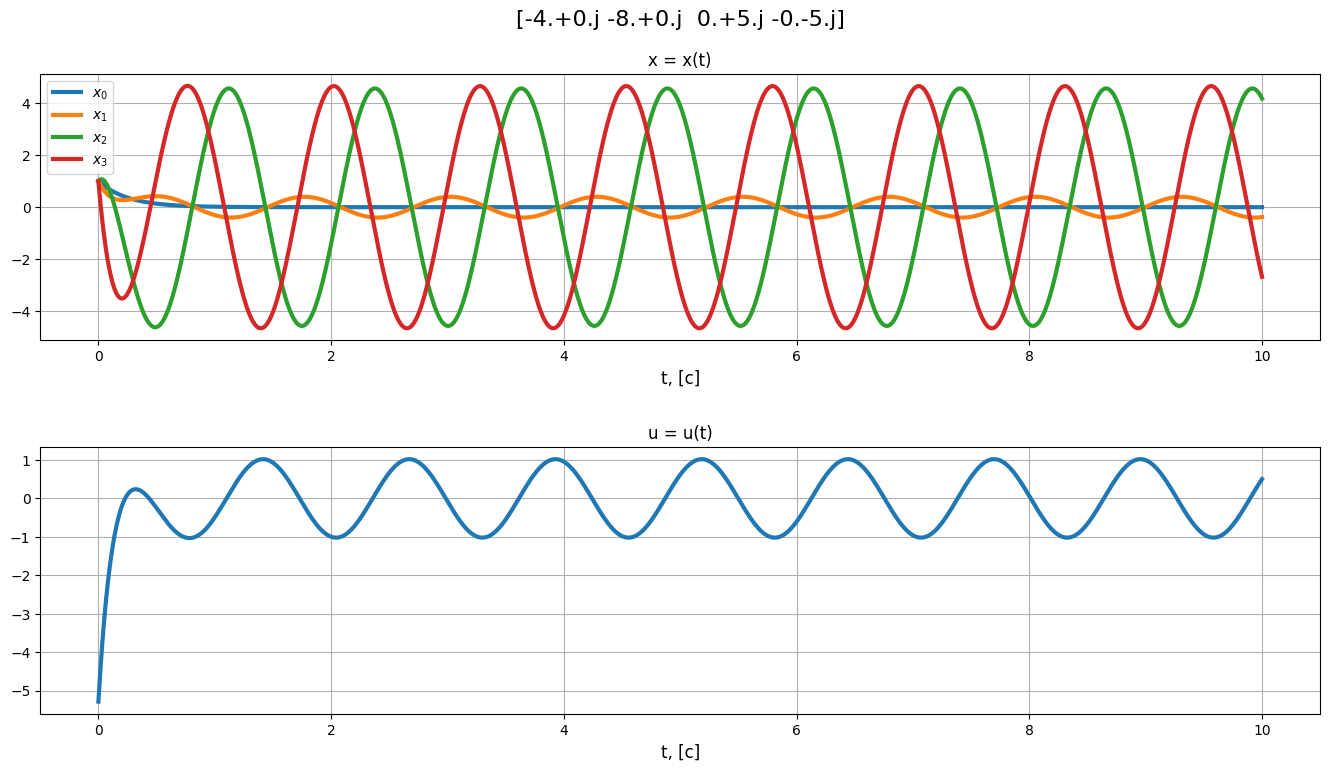

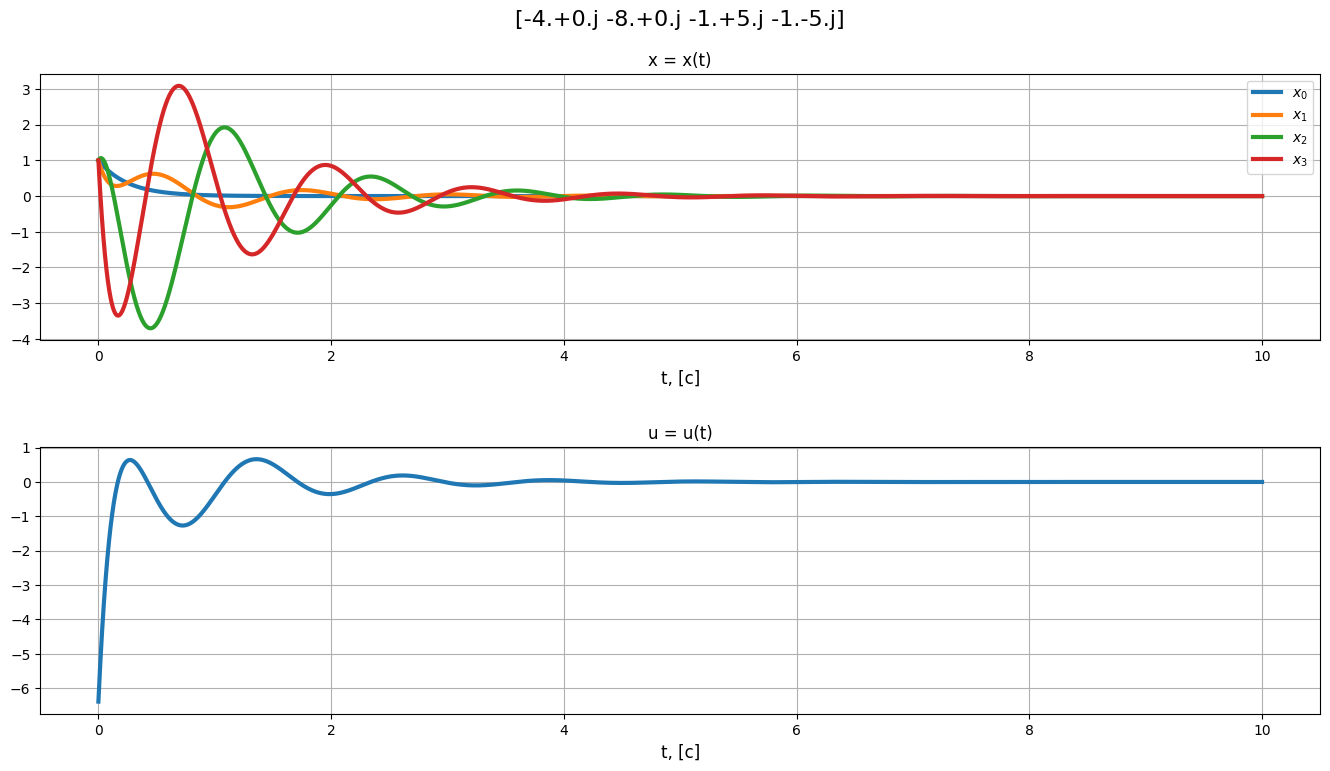

In [31]:
task1_ks = dict()
for indx, specs in enumerate(task1_eigvals):
    print(f'\n======== {specs} ========')
    new_g = task1_get_G(specs)
    new_y = np.ones((task1_B.shape[1], task1_A.shape[0]))
    print(f"Y: \n{new_y}")
    new_y[0, 0] = 0
    # print(f'G:\n{new_g}')
    # print(f'Y:\n{new_y}')
    
    K = task1_get_K(task1_A, task1_B, new_g, new_y).astype(np.float64)
    new_spec = np.linalg.eigvals(task1_A + task1_B @ K)
    print(f"new_spec: \n{new_spec}")
    task1_ks[indx] = K
    check_observability(new_y, new_g)
    check_observability_eigens(new_y, new_g)
    
    print(f'K = {K}')
    print(a2l.to_ltx(K, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
    
    ts = get_t(10)
    res = task1_simulate(task1_A, task1_B, K, task1_x0, ts)

    fig, axs = plt.subplots(2, figsize=(16, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    fig.suptitle(f'{specs}', fontsize=16)
    for i in range(4):
        axs[0].plot(ts, res.states[i], linewidth = 3, label=f'$x_{i}$')
    axs[0].grid(True)
    axs[0].legend()
    axs[0].set_title(f'x = x(t)', fontsize=12)
    axs[0].set_xlabel(f"t, [c]", fontsize=12)

    axs[1].plot(ts, (K @ res.states).reshape(-1), linewidth = 3)
    axs[1].grid(True)
    axs[1].set_title(f'u = u(t)', fontsize=12)
    axs[1].set_xlabel(f"t, [c]", fontsize=12)

# Задание 2

## Шаг 1

In [32]:
task2_A = np.array([
    [0, 4, 0, 0],
    [-4, 0, 0, 0],
    [0, 0, 0, 3],
    [0, 0, -3, 0]
])

task2_C = np.array([[5, 0, 0, 9]])

task2_eigvals = np.array([
    [-4, -4, -4, -4],
    [-4, -40, -400, -400],
    [-4, -8, 5j, -5j],
    [-4, -8, -1 + 5j, -1 - 5j],
])

task2_x0 = np.array([1, 1, 1, 1])
task2_xh0 = np.array([2, 0, 0, -1])

In [33]:
eig_vals = np.linalg.eigvals(task2_A)
eig_vals

array([0.+4.j, 0.-4.j, 0.+3.j, 0.-3.j])

In [34]:
for val in eig_vals:
    print(f"   {val}: {'observable' if np.linalg.matrix_rank(np.vstack(((task2_A - val * np.eye(task2_A.shape[0])), task2_C))) == task2_A.shape[0] else 'not observable'}")

   4j: observable
   -4j: observable
   2.9999999999999996j: observable
   -2.9999999999999996j: observable


## Шаг 3

In [35]:
def task2_simulate(A, C, L, x0, xh0, ts):
    ss_orig = control.ss(A, np.zeros((A.shape[0], 1)), C, np.zeros((C.shape[0], 1)))
    original_resp = control.forced_response(ss_orig, X0=x0, T=ts)
    ss = control.ss(A + L@C, L, A*0, L*0)
    return original_resp, control.forced_response(ss, X0=xh0, T=ts, U=original_resp.outputs.reshape(-1))

def task2_get_L(A, C, G, Y):
    Q = cvxpy.Variable(A.shape)
    objective = cvxpy.Minimize(cvxpy.sum_squares(G @ Q - Q @ A - Y @ C))
    prob = cvxpy.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(Q.value)}')
    return np.linalg.pinv(Q.value) @ Y


======== [-4.+0.j -4.+0.j -4.+0.j -4.+0.j] ========
Gamma: 
[[-4.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -4.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -4.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -4.+0.j]]
Gamma: 
[[-4.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -4.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -4.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -4.+0.j]]
Y: 
[[1.]
 [1.]
 [1.]
 [1.]]
Optimization error: 7.888609052210118e-31, rankP = 4
RankU = 4
Eigen values of A:
   [-4.+0.j]: controllable
   [-4.+0.j]: controllable
   [-4.+0.j]: controllable
   [-4.+0.j]: controllable
L = [[ 2.04636308e-12]
 [-7.31428571e+00]
 [-2.78835979e+00]
 [-1.77777778e+00]]
\begin{bmatrix}
  0.00 & -7.31 & -2.79 & -1.78
\end{bmatrix}
[-4.00367045+0.j         -3.99999838+0.00366883j -3.99999838-0.00366883j
 -3.99633279+0.j        ]


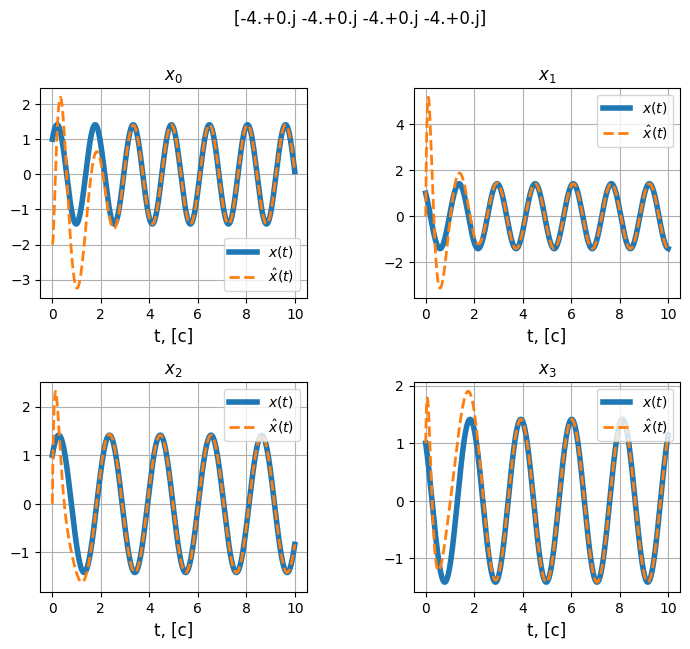

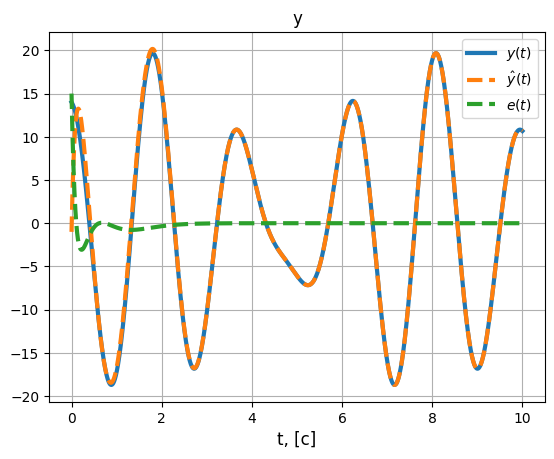


======== [  -4.+0.j  -40.+0.j -400.+0.j -400.+0.j] ========
Gamma: 
[[  -4.+0.j    0.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j  -40.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j    0.+0.j -400.+0.j    1.+0.j]
 [   0.+0.j    0.+0.j    0.+0.j -400.+0.j]]
Gamma: 
[[  -4.+0.j    0.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j  -40.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j    0.+0.j -400.+0.j    1.+0.j]
 [   0.+0.j    0.+0.j    0.+0.j -400.+0.j]]
Y: 
[[1.]
 [1.]
 [1.]
 [1.]]
Optimization error: 1.5812366325905303e-30, rankP = 4
RankU = 4
Eigen values of A:
   [-4.+0.j]: controllable
   [-40.+0.j]: controllable
   [-400.+0.j]: controllable
   [-400.+0.j]: controllable
L = [[ 204414.17137173]
 [ 160532.11424014]
 [ 126147.30684271]
 [-113657.20631761]]
\begin{bmatrix}
  204414.17 &  160532.11 &  126147.31 & -113657.21
\end{bmatrix}
[-400.02255737 -399.9774408   -40.00000171   -3.99999997]


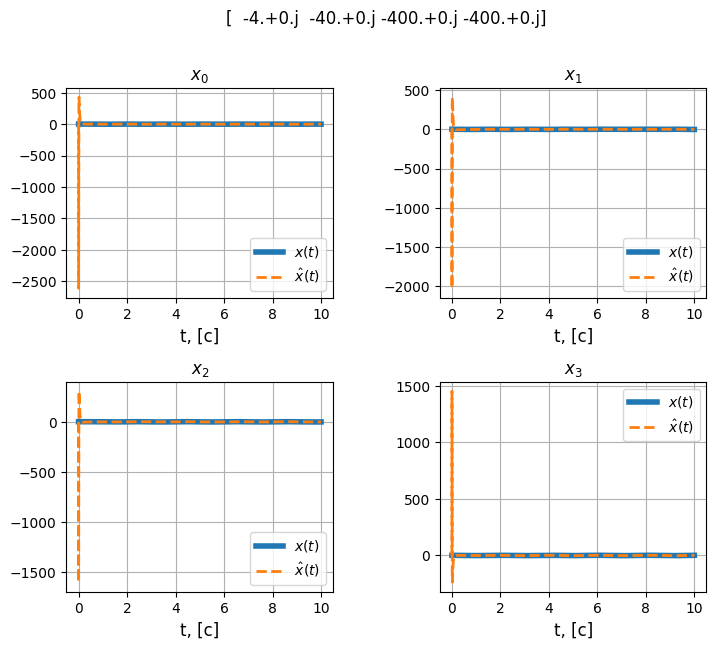

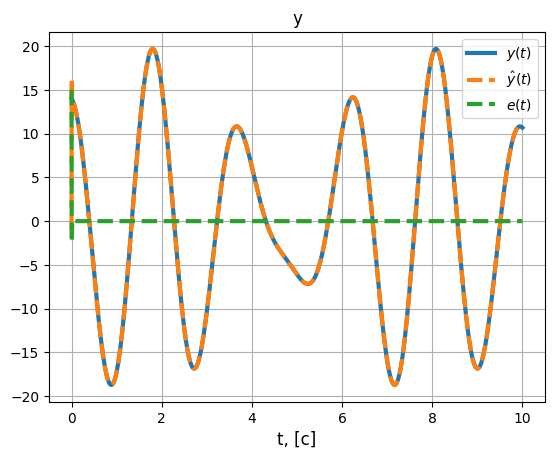


======== [-4.+0.j -8.+0.j  0.+5.j -0.-5.j] ========
Gamma: 
[[-4.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -8.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  5.+0.j]
 [ 0.+0.j  0.+0.j -5.+0.j  0.+0.j]]
Gamma: 
[[-4.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -8.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  5.+0.j]
 [ 0.+0.j  0.+0.j -5.+0.j  0.+0.j]]
Y: 
[[1.]
 [1.]
 [1.]
 [1.]]
Optimization error: 1.262177448353619e-29, rankP = 4
RankU = 4
Eigen values of A:
   [0.+5.j]: controllable
   [-2.22044605e-16-5.j]: controllable
   [-4.+0.j]: controllable
   [-8.+0.j]: controllable
L = [[ 3.08571429]
 [ 1.02857143]
 [ 1.94708995]
 [-3.04761905]]
\begin{bmatrix}
  3.09 &  1.03 &  1.95 & -3.05
\end{bmatrix}
[-5.44009282e-15+5.j -5.44009282e-15-5.j -8.00000000e+00+0.j
 -4.00000000e+00+0.j]


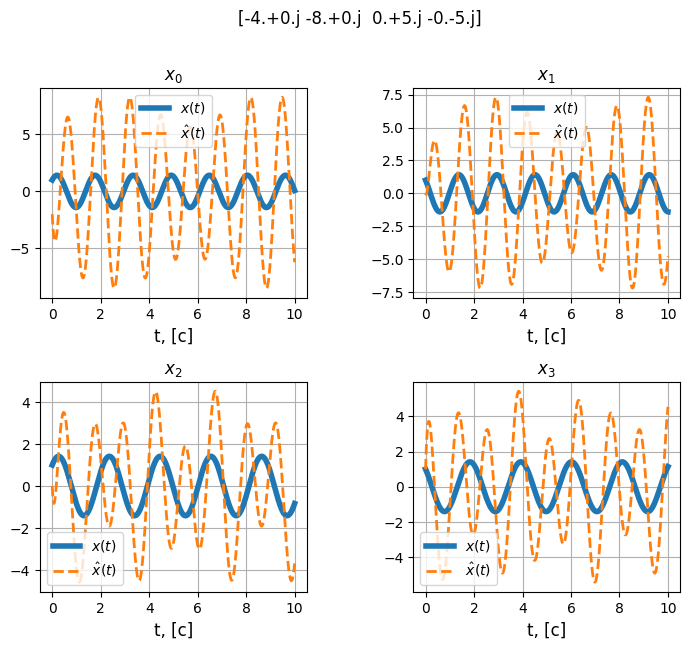

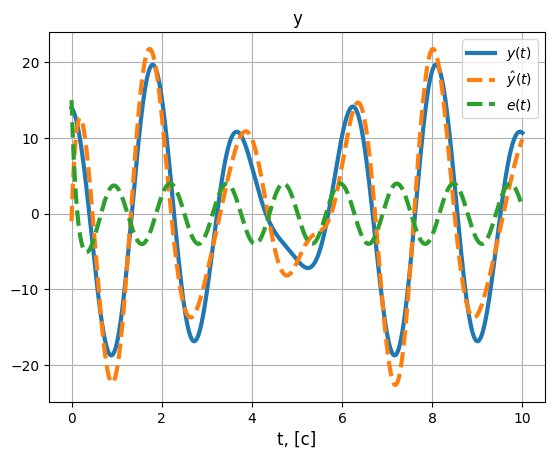


======== [-4.+0.j -8.+0.j -1.+5.j -1.-5.j] ========
Gamma: 
[[-4.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -8.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  5.+0.j]
 [ 0.+0.j  0.+0.j -5.+0.j -1.+0.j]]
Gamma: 
[[-4.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -8.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  5.+0.j]
 [ 0.+0.j  0.+0.j -5.+0.j -1.+0.j]]
Y: 
[[1.]
 [1.]
 [1.]
 [1.]]
Optimization error: 9.466330862652142e-30, rankP = 4
RankU = 4
Eigen values of A:
   [-1.+5.j]: controllable
   [-1.-5.j]: controllable
   [-4.+0.j]: controllable
   [-8.+0.j]: controllable
L = [[ 4.34285714]
 [-1.6       ]
 [ 0.92592593]
 [-3.96825397]]
\begin{bmatrix}
  4.34 & -1.60 &  0.93 & -3.97
\end{bmatrix}
[-8.+0.j -1.+5.j -1.-5.j -4.+0.j]


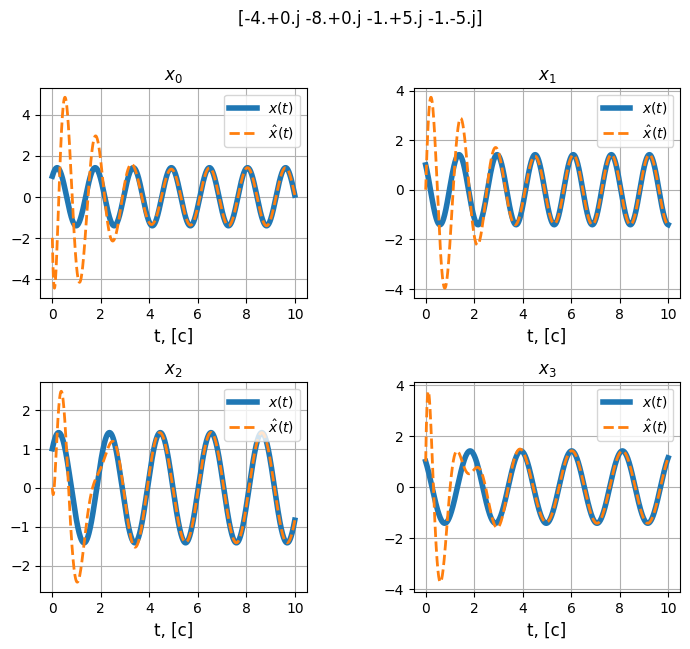

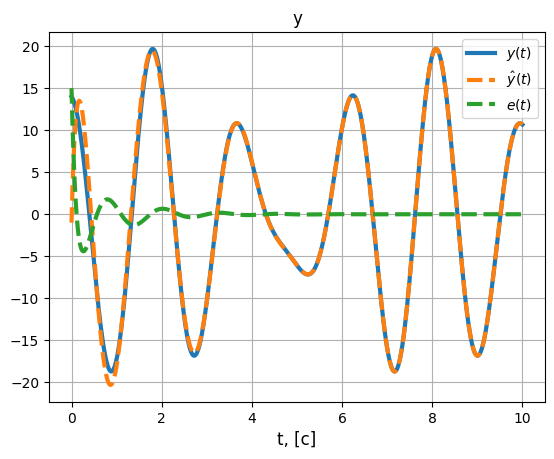

In [36]:
for indx, specs in enumerate(task2_eigvals):
    print(f'\n======== {specs} ========')
    new_g = task1_get_G(specs)
    print(f"Gamma: \n{new_g}")
    new_y = np.ones((task1_A.shape[0], task2_C.shape[0]))
    print(f"Y: \n{new_y}")
    
    L = task2_get_L(task2_A, task2_C, new_g, new_y).astype(np.float64)
    check_controllability(new_g, new_y)
    check_controllability_eigens(new_g, new_y)
    
    print(f'L = {L}')
    print(a2l.to_ltx(L.T, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
    print(np.linalg.eigvals(task2_A + L @ task2_C))
    
    ts = get_t(10)
    original_resp, observer_resp = task2_simulate(task2_A, task2_C, L, task2_x0, task2_xh0, ts)

    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    plt.subplots_adjust(left=0.1, bottom=0.01, right=0.9, top=0.85, wspace=0.4,hspace=0.4)
    fig.suptitle(f'{specs}', fontsize=12)
    for i in range(original_resp.states.shape[0]):
        axs[i//2, i % 2].plot(ts, original_resp.states[i], linewidth=4, label="$x(t)$")
        axs[i//2, i % 2].plot(ts, -observer_resp.states[i], '--', linewidth = 2, label="$\hat x(t)$")
        axs[i//2, i % 2].set_title(f'$x_{i}$', fontsize=12)
        axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
        axs[i//2, i % 2].grid(True)
        axs[i//2, i % 2].legend()
    plt.legend()
    plt.show()
    
    plt.plot(ts, original_resp.outputs.reshape(-1), linewidth = 3, label="$y(t)$")
    plt.plot(ts, -(task2_C @ observer_resp.states).reshape(-1), '--', linewidth = 3, label="$\hat y(t)$")
    plt.plot(ts, original_resp.outputs.reshape(-1) + (task2_C @ observer_resp.states).reshape(-1), '--', linewidth = 3, label="$ e(t) $")
    
    plt.grid(True)
    plt.title(f'y', fontsize=12)
    plt.xlabel(f"t, [c]", fontsize=12)
    
    plt.legend()
    plt.show()

# Задание 3

## Шаг 1

In [37]:
task3_A = np.array([
    [5, -5, -9, 3],
    [-5, 5, -3, 9],
    [-9, -3, 5, 5],
    [3, 9, 5, 5]
])

task3_B = np.array([[2], 
                    [6], 
                    [6], 
                    [2]])

task3_C = np.array([
    [1, -1, 1, 1],
    [1, 3, -1, 3]
                    ])

specs = [-12, -3, -2, -1]

In [38]:
eig_vals = np.linalg.eigvals(task3_A)
eig_vals

array([-12.,   4.,  16.,  12.])

In [39]:
for val in eig_vals:
    print(f"   {val}: {'controllable' if np.linalg.matrix_rank(np.hstack(((task1_A - val * np.eye(task1_A.shape[0])), task1_B))) == task1_A.shape[0] else 'not controllable'}")

   -12.00000000000001: controllable
   4.0000000000000036: controllable
   16.000000000000004: controllable
   12.000000000000004: controllable


In [40]:
for val in eig_vals:
    print(f"   {val}: {'observable' if np.linalg.matrix_rank(np.vstack(((task2_A - val * np.eye(task2_A.shape[0])), task2_C))) == task2_A.shape[0] else 'not observable'}")

   -12.00000000000001: observable
   4.0000000000000036: observable
   16.000000000000004: observable
   12.000000000000004: observable


## Шаг 3

In [52]:
specs = [-12, -3, -2, -1]

In [55]:
# specs = [-4, -1, -2, -3]
new_g = task1_get_G(specs)
new_y = np.ones((task3_B.shape[1], task3_A.shape[0]))
print(f'G:\n{new_g}')
print(f'Y:\n{new_y}')

K = task1_get_K(task3_A, task3_B, new_g, new_y).astype(np.float64)
print(f"K: \n{K}")

Gamma: 
[[-12   0   0   0]
 [  0  -3   0   0]
 [  0   0  -2   0]
 [  0   0   0  -1]]
G:
[[-12   0   0   0]
 [  0  -3   0   0]
 [  0   0  -2   0]
 [  0   0   0  -1]]
Y:
[[1. 1. 1. 1.]]
Optimization error: 36.0, rankP = 4
K: 
[[ 38.32113206  15.20230628 -39.93113804  13.78159416]]


In [54]:
check_observability(new_y, new_g)
check_observability_eigens(new_y, new_g)

RankV = 4
Eigen values of A:
   [-12.]: observable
   [-3.]: observable
   [-2.]: observable
   [-1.]: observable


In [60]:
specs = [-12, -3, -2, -1]
new_g = task1_get_G(specs)
new_y = np.ones((task3_A.shape[0], task3_C.shape[0]))
print(new_g)
new_y[0, :] = 0
print(new_y)


L = task2_get_L(task3_A, task3_C, new_g, new_y).astype(np.float64)
print(f"L: \n{L}")
check_controllability(new_g, new_y)
check_controllability_eigens(new_g, new_y)

Gamma: 
[[-12   0   0   0]
 [  0  -3   0   0]
 [  0   0  -2   0]
 [  0   0   0  -1]]
[[-12   0   0   0]
 [  0  -3   0   0]
 [  0   0  -2   0]
 [  0   0   0  -1]]
[[0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
Optimization error: 3.347266243345016e-30, rankP = 3
L: 
[[ 40.3984375  40.3984375]
 [-19.0703125 -19.0703125]
 [-41.4921875 -41.4921875]
 [-20.1640625 -20.1640625]]
RankU = 3
Eigen values of A:
   [-12.]: not controllable
   [-3.]: controllable
   [-2.]: controllable
   [-1.]: controllable


In [61]:
L

array([[ 40.3984375,  40.3984375],
       [-19.0703125, -19.0703125],
       [-41.4921875, -41.4921875],
       [-20.1640625, -20.1640625]])

In [62]:
task3_new_A = np.block([[task3_A + task3_B @ K, -task3_B @ K], [np.zeros((task3_A.shape[0], K.shape[1] * 2 - task3_C.shape[1])), task3_A + L @ task3_C]])
task3_new_A

array([[  81.64226412,   25.40461257,  -88.86227608,   30.56318833,
         -76.64226412,  -30.40461257,   79.86227608,  -27.56318833],
       [ 224.92679237,   96.2138377 , -242.58682824,   91.68956498,
        -229.92679237,  -91.2138377 ,  239.58682824,  -82.68956498],
       [ 220.92679237,   88.2138377 , -234.58682824,   87.68956498,
        -229.92679237,  -91.2138377 ,  239.58682824,  -82.68956498],
       [  79.64226412,   39.40461257,  -74.86227608,   32.56318833,
         -76.64226412,  -30.40461257,   79.86227608,  -27.56318833],
       [   0.        ,    0.        ,    0.        ,    0.        ,
          85.796875  ,   75.796875  ,   -9.        ,  164.59375   ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
         -43.140625  ,  -33.140625  ,   -3.        ,  -67.28125   ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
         -91.984375  ,  -85.984375  ,    5.        , -160.96875   ],
       [   0.        ,    0.        ,    

In [63]:
x0 = np.ones((task3_A.shape[0]*2))
x0

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [64]:
ss = control.ss(task3_new_A, task3_new_A * 0, task3_new_A * 0, task3_new_A * 0)

ts = get_t(15)
res = control.forced_response(ss, T=ts, X0=np.ones((task3_A.shape[0]*2)))
x = res.states[:4]
e = res.states[4:]

xh = x - e
y = task3_C @ x
yh = task3_C @ xh

u = K @ xh

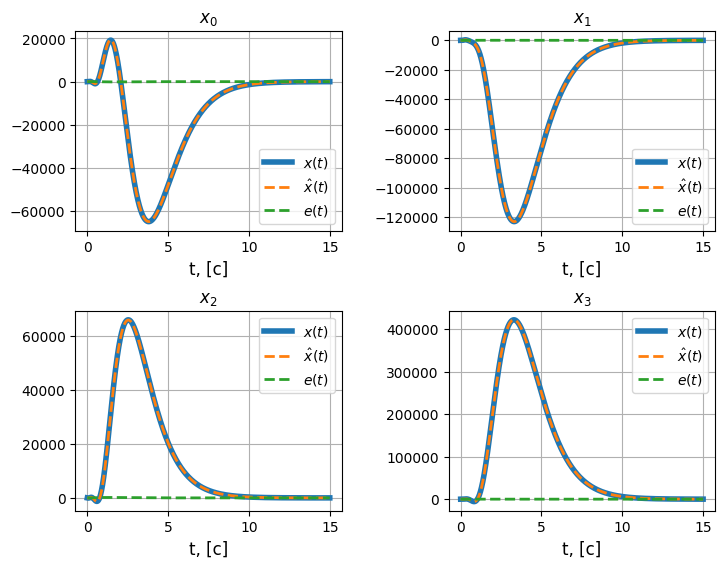

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for i in range(original_resp.states.shape[0]):
    axs[i//2, i % 2].plot(ts, x[i], linewidth=4, label="$x(t)$")
    axs[i//2, i % 2].plot(ts, xh[i], '--', linewidth = 2, label="$\hat x(t)$")
    axs[i//2, i % 2].plot(ts, e[i], '--', linewidth = 2, label="$e(t)$")
    axs[i//2, i % 2].set_title(f'$x_{i}$', fontsize=12)
    axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i % 2].grid(True)
    axs[i//2, i % 2].legend()

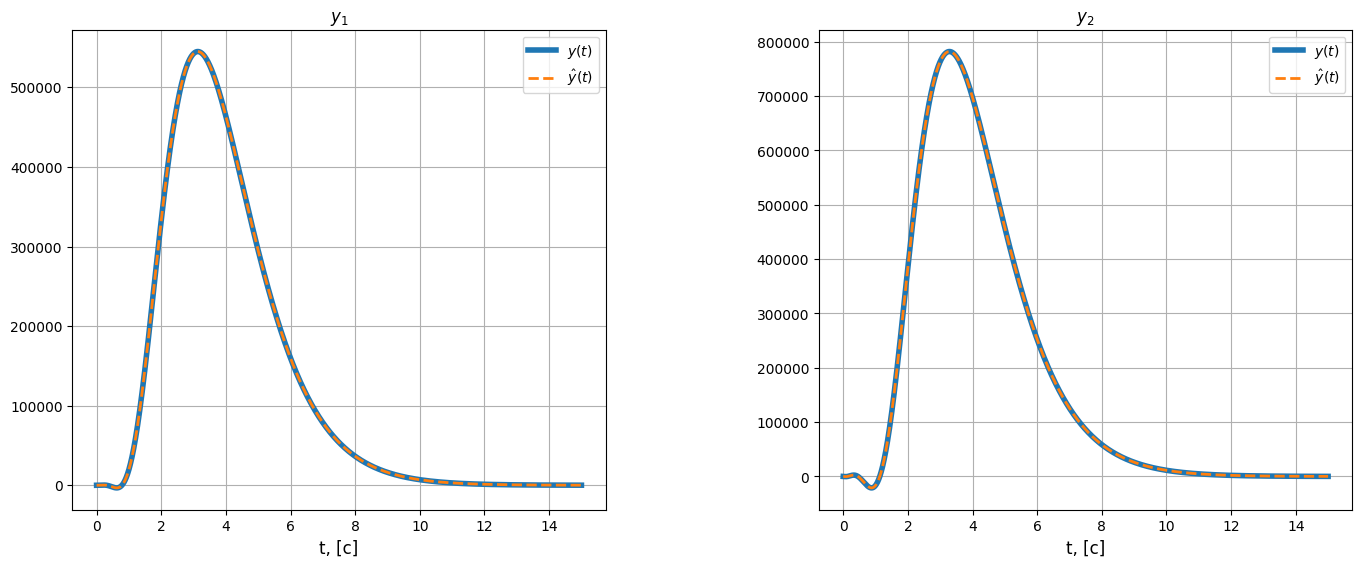

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axs[0].plot(ts, y[0], linewidth=4, label='$y(t)$')
axs[0].plot(ts, yh[0], '--', linewidth=2,label='$\hat y(t)$')
axs[0].set_title(f'$y_1$', fontsize=12)
axs[0].set_xlabel(f"t, [c]", fontsize=12)
axs[0].grid(True)
axs[0].legend()

axs[1].plot(ts, y[1], linewidth=4, label="$y(t)$")
axs[1].plot(ts, yh[1], '--', linewidth=2, label="$\hat y(t)$")
axs[1].set_title(f'$y_2$', fontsize=12)
axs[1].set_xlabel(f"t, [c]", fontsize=12)
axs[1].grid(True)
axs[1].legend()


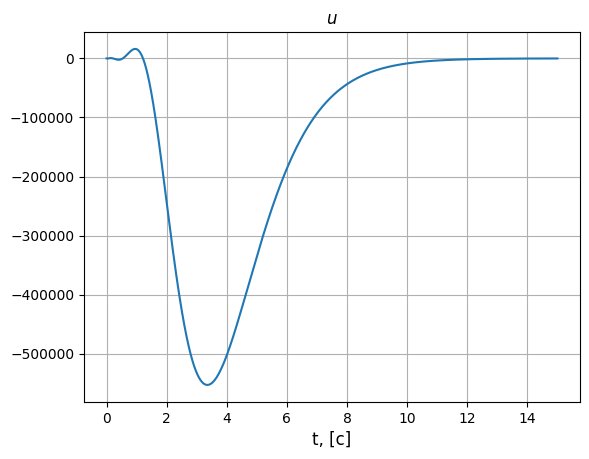

In [67]:
plt.plot(ts, u.reshape(-1))
plt.title(f'$u$', fontsize=12)
plt.xlabel(f"t, [c]", fontsize=12)
plt.grid(True)